## Multi-label classification

In [53]:
# !mkdir -p /root/data/planet
# !aws --endpoint-url https://blob.mr3.simcloud.apple.com --cli-read-timeout 300 s3 cp s3://course.fast.ai/data2.zip /root/data/planet
# !unzip /root/data/planet/data2.zip -d /root/data/planet/

In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [55]:
from fastai.conv_learner import *

In [56]:
PATH = 'data/planet/'

In [57]:
# Data preparation steps if you are using Crestle:

# os.makedirs('data/planet/models', exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [75]:
!ls {PATH}

__MACOSX  sample_submission_v2.csv  test_v2_file_mapping.csv  train-jpg
models	  test-jpg		    tmp			      train_v2.csv


In [59]:
!ls {PATH}/train-jpg | wc

  40479   40479  636554


In [60]:
!ls {PATH}/test-jpg | wc

  61191   61191  895645


In [61]:
! head -n 5 {PATH}/test_v2_file_mapping.csv

## Multi-label versus single-label classification

In [62]:
from fastai.plots import *

In [63]:
def get_1st(path): return glob(f'{path}/*.*')[0]

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

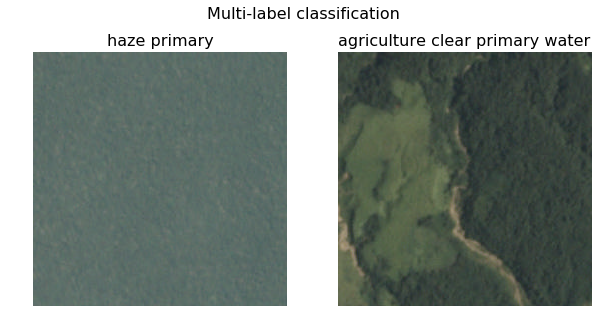

In [64]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [65]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [66]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [67]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [68]:
data = get_data(256)

In [69]:
x,y = next(iter(data.val_dl))

In [70]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [71]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


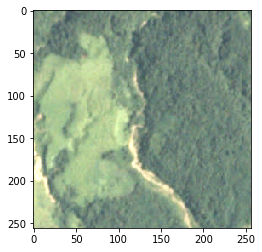

In [72]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*2);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp')

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.22597    0.266166   0.793181  



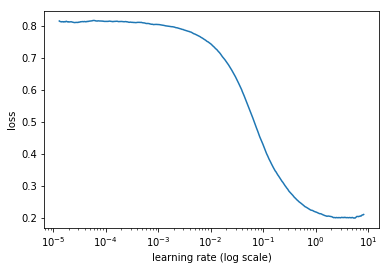

In [22]:
lrf=learn.lr_find()
learn.sched.plot()

In [51]:
lr = 0.2

In [77]:
learn.fit(lr, 1, cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   f2                          
    0      0.124384   0.119701   0.895774  



[array([0.1197]), 0.8957737055105095]

# Checking out the model

In [25]:
df = pd.read_csv(f'{PATH}/train_v2.csv')

In [29]:
!ls {PATH}

__MACOSX		  test-jpg		    tmp
models			  test-jpg-additional	    train-jpg
sample_submission_v2.csv  test_v2_file_mapping.csv  train_v2.csv


In [30]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [40]:
def explore_image(img_num, df):
    datapath = 'data/planet/train-jpg/'
    img_path = os.path.join(datapath, f'train_{img_num}.jpg')
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.figure(2)
    plt.imshow(img*2)
    plt.figure(3)
    plt.imshow(img*3)
    print(df.loc[df['image_name'] == img_path.split('/')[-1].split('.jpg')[0]])

In [81]:
def explore_image2(img_num):
    datapath = 'data/planet/test-jpg/'
    img_path = os.path.join(datapath, f'file_{img_num}.jpg')
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.figure(2)
    plt.imshow(img*2)
    plt.figure(3)
    plt.imshow(img*3)

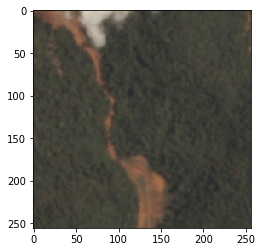

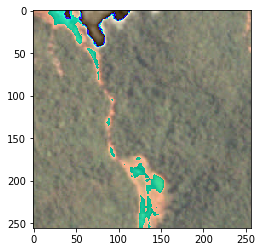

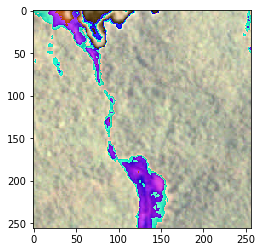

In [84]:
explore_image2(19150)

  image_name          tags
0    train_0  haze primary


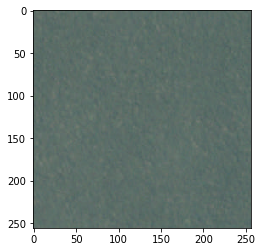

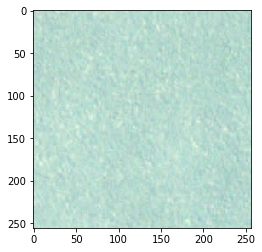

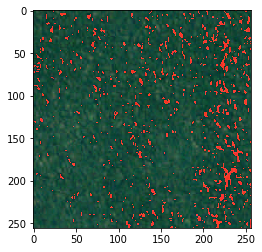

In [49]:
explore_image(0, df)

  image_name                tags
5    train_5  haze primary water


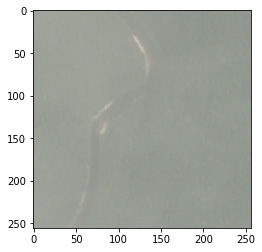

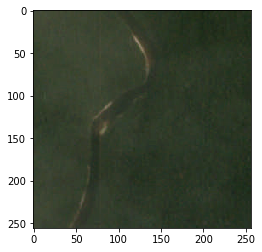

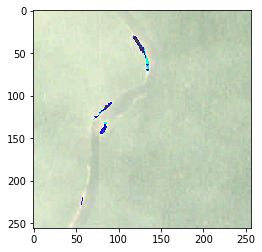

In [50]:
explore_image(5, df)

      image_name                   tags
1573  train_1573  partly_cloudy primary


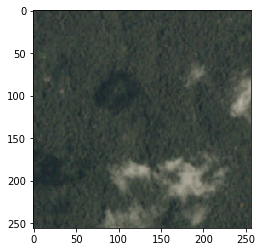

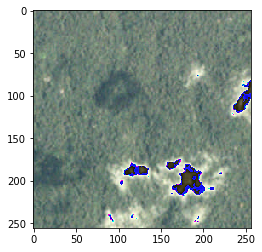

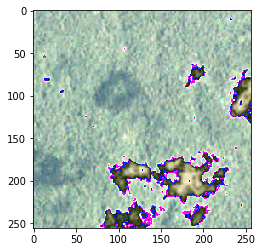

In [78]:
explore_image(1573, df)

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. The most correct labels of each class (i.e. those with highest probability that are correct)
1. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
1. The most uncertain labels (i.e. those with probability closest to 0.5).

In [35]:
# most correct labels

In [97]:
log_preds = learn.predict()
log_preds.shape

(8095, 17)

In [98]:
len(data.classes)

17

In [99]:
!ls {PATH}/train-jpg | wc

  40479   40479  636554


In [100]:
40479*.20 # 20% for the validation set

8095.8

In [101]:
log_preds[0][:10]

array([0.92433, 0.0003 , 0.00822, 0.00036, 0.00059, 0.9778 , 0.00017, 0.00041, 0.21022, 0.17985],
      dtype=float32)

In [106]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [107]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [108]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [109]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(os.path.join(PATH, ds.fnames[idx])))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [110]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


ValueError: a must be non-empty

In [111]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [112]:
class_num = 1
plot_val_with_title(most_by_correct(class_num, True), f"Most correct {data.classes[class_num]}")

Most correct artisinal_mine


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  import sys


<Figure size 1152x576 with 0 Axes>

In [114]:
log_preds[0]

array([0.92433, 0.0003 , 0.00822, 0.00036, 0.00059, 0.9778 , 0.00017, 0.00041, 0.21022, 0.17985, 0.00732,
       0.01585, 0.99848, 0.56007, 0.00175, 0.00543, 0.32106], dtype=float32)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [123]:
df_submit = pd.DataFrame.from_records(log_preds)

In [125]:
df_submit.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
8090,0.117946,0.000297,0.008485,0.005742,0.003413,0.898104,0.000431,0.000168,0.142681,0.016139,0.001024,0.246425,0.998657,0.049307,0.013021,0.002433,0.138252
8091,0.508293,0.000206,0.012872,0.002771,0.001554,0.934319,0.000587,0.001119,0.133196,0.146416,0.010068,0.064421,0.996910,0.368664,0.011011,0.004457,0.745102
8092,0.235148,0.000730,0.008456,0.002851,0.004721,0.980954,0.000408,0.000605,0.059768,0.027734,0.001297,0.038236,0.998552,0.127761,0.007900,0.001839,0.101543
8093,0.260340,0.002752,0.010148,0.009917,0.003969,0.167327,0.000226,0.000784,0.316971,0.030113,0.000701,0.886587,0.999648,0.046687,0.017192,0.006176,0.056137
8094,0.817970,0.001632,0.034410,0.002620,0.003835,0.512587,0.005436,0.000760,0.262721,0.120426,0.237420,0.290755,0.979415,0.247459,0.003777,0.006679,0.129292


# Further training

In [44]:
lrs = np.array([lr/9,lr/3,lr])

In [48]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.117073   0.10958    0.908011  
    1      0.114036   0.10564    0.911777                    
    2      0.108899   0.101661   0.913208                    
    3      0.111137   0.105219   0.912898                    
    4      0.106248   0.101596   0.914855                    
    5      0.099328   0.098493   0.917918                     
    6      0.097733   0.097629   0.918455                     



[array([0.09763]), 0.9184548755995126]

In [49]:
learn.save(f'{sz}')

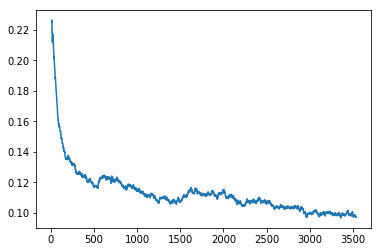

In [50]:
learn.sched.plot_loss()

In [51]:
sz=128

In [52]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.098797   0.096123   0.917822  
    1      0.098141   0.094262   0.920156                     
    2      0.093693   0.094118   0.91989                      
    3      0.095877   0.09433    0.919197                     
    4      0.09661    0.093562   0.920169                     
    5      0.093149   0.092836   0.920516                     
    6      0.095515   0.09338    0.919888                     



[array([0.09338]), 0.9198880322444909]

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

 69%|██████▉   | 348/506 [00:43<00:19,  7.92it/s, loss=0.0937]

# Let's take a look at the data performance

# One more size upgrade and final training

In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [26]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [27]:
f2(preds,y)

0.93626519738612801

### End